In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download dansbecker/cityscapes-image-pairs   
! unzip cityscapes-image-pairs.zip

Streaming output truncated to the last 5000 lines.
  inflating: cityscapes_data/cityscapes_data/train/2754.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2755.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2756.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2757.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2758.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2759.jpg  
  inflating: cityscapes_data/cityscapes_data/train/276.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2760.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2761.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2762.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2763.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2764.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2765.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2766.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2767.jpg  
  inflating: citysca

In [2]:
'''
TO DO:

1. Activations due to images in the Step Down network using HeatMaps
2. t-SNE analysis of the latent space for different classes and for the objects in different regions of the image.

'''


'''
APPROACH :
1. Use the straight forward dataset and feed it in a bigger model and get the output
2. Use the masking and colouring the pixels on basis of class, so that we have clear picture of dataset 
and hence feeding it in a lesser size Unets will also give nice results.
3. If RAM crashes then to it in Batches
'''

'\nAPPROACH :\n1. Use the straight forward dataset and feed it in a bigger model and get the output\n2. Use the masking and colouring the pixels on basis of class, so that we have clear picture of dataset \nand hence feeding it in a lesser size Unets will also give nice results.\n3. If RAM crashes then to it in Batches\n'

In [18]:
import os
from os import walk
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt

train_location = 'cityscapes_data/train/'
val_location = 'cityscapes_data/val/'
CLASSES = 13
HEIGHT = 256
WIDTH = 256
num_of_train = len(os.listdir(train_location))
num_of_val = len(os.listdir(val_location))
BATCH_SIZE = 10
lr = 1e-4
batch_size = 10   # 8
EPOCHS = 1

In [4]:
# training data preparation if you have ENOUGH RAM

#######   ON SEEING THE IMAGES WE CAN AY THAT WE HAVE TO FISRT REFINE THE Semantics of Image.

train_set_X = []
train_set_Y = []


############### ANOTHER WAY TO GET THE DATASET   ##################

# for (dir_path, dir_names, file_names) in walk(train_location):
#     #train_set.extend(file_names)
#     break

# for img_name in file_names:
#    image = cv2.imread(train_location + str(img_name))
#    [rows, cols, _] = image.shape
#    X = image[0:rows, 0:cols//2]
#    Y = image[0:rows, cols//2:cols]
#    train_set_X.append(X)
#    train_set_Y.append(Y)

###################################################################

for img_name in tqdm(os.listdir(train_location)):
   image = cv2.imread(train_location + str(img_name))
   [rows, cols, _] = image.shape
   X = image[0:rows, 0:cols//2]
   Y = image[0:rows, cols//2:cols]
   train_set_X.append(X)
   train_set_Y.append(Y)
   train_set_X.append(X)
   train_set_Y.append(Y)

train_set_X = np.array(train_set_X)
train_set_Y = np.array(train_set_Y)
np.save('Train_X.npy', train_set_X)
np.save('Train_Y.npy', train_set_Y)


100%|██████████| 2975/2975 [00:06<00:00, 453.35it/s]


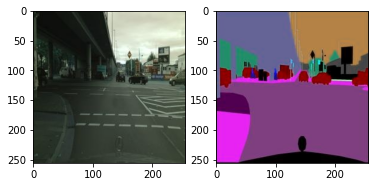

In [5]:
%matplotlib inline
plt.subplot(1,2,1)
plt.imshow(train_set_X[0])
plt.subplot(1,2,2)
plt.imshow(train_set_Y[0])
plt.show()

In [6]:
# Validation Data Preparation 

# training data preparation

val_set_X = []
val_set_Y = []


############### ANOTHER WAY TO GET THE DATASET   ##################

# for (dir_path, dir_names, file_names) in walk(train_location):
#     #train_set.extend(file_names)
#     break

# for img_name in file_names:
#    image = cv2.imread(train_location + str(img_name))
#    [rows, cols, _] = image.shape
#    X = image[0:rows, 0:cols//2]
#    Y = image[0:rows, cols//2:cols]
#    train_set_X.append(X)
#    train_set_Y.append(Y)

###################################################################

for img_name in tqdm((os.listdir(val_location))):
   image = cv2.imread(val_location + str(img_name))
   [rows, cols, _] = image.shape
   X = image[0:rows, 0:cols//2]
   Y = image[0:rows, cols//2:cols]
   val_set_X.append(X)
   val_set_Y.append(Y)

val_set_X = np.array(val_set_X)
val_set_Y = np.array(val_set_Y)
np.save('val_X.npy', val_set_X)
np.save('val_Y.npy', val_set_Y)



100%|██████████| 500/500 [00:01<00:00, 479.36it/s]


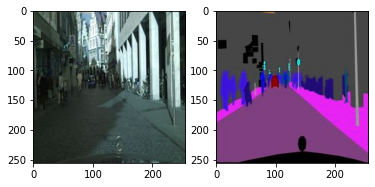

In [7]:
%matplotlib inline
plt.subplot(1,2,1)
plt.imshow(val_set_X[0])
plt.subplot(1,2,2)
plt.imshow(val_set_Y[0])
plt.show()

# PREPRARING U-NETS MODEL

In [8]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [9]:
def Conv_blocks(inputs, filters, pool=True):

  x = Conv2D(filters, 3, padding='same')(inputs)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(filters, 3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  if pool == True:
    p = MaxPool2D((2,2))(x)   # it was p before
    return x, p 
  else:
    return x

def UNETS(shape, num_classes):
   
   inputs = Input(shape)
   
   ''' ENCODER BLOCK '''

   x1, p1 = Conv_blocks(inputs, 16, pool=True)   # 64, 128, 256, 512
   x2, p2 = Conv_blocks(p1, 32, pool=True)
   x3, p3 = Conv_blocks(p2, 48, pool=True)
   x4, p4 = Conv_blocks(p3, 64, pool=True)

   ''' BRIDGE '''

   b = Conv_blocks(p4, 128, pool=False)

   ''' DECODER BLOCK '''

   u1 = UpSampling2D((2,2), interpolation='bilinear')(b)
   c1 = Concatenate()([u1, x4])
   x5 = Conv_blocks(c1, 64, pool=False)

   u2 = UpSampling2D((2,2), interpolation='bilinear')(x5)
   c2 = Concatenate()([u2, x3])
   x6 = Conv_blocks(c2, 48, pool=False)

   u3 = UpSampling2D((2,2), interpolation='bilinear')(x6)
   c3 = Concatenate()([u3, x2])
   x7 = Conv_blocks(c3, 32, pool=False)

   u4 = UpSampling2D((2,2), interpolation='bilinear')(x7)
   c4 = Concatenate()([u4, x1])
   x8 = Conv_blocks(c4, 16, pool=False)

   ''' OUTPUT LAYER '''

   Output = Conv2D(num_classes, 1, padding="same", activation='softmax')(x8)

   return Model(inputs, Output)

model = UNETS((256,256,3), 3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# TRAINING DATA

In [10]:
print("DATASET SUMMARY :")
print(f"Number of Training Set Sample - {len(train_set_X)}\nNumber of Validation Set Samples - {len(val_set_X)}")

DATASET SUMMARY :
Number of Training Set Sample - 5950
Number of Validation Set Samples - 500


In [11]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr))

In [19]:
###  Training in Batches:

train_steps_per_epo = len(train_set_X) // batch_size
valid_steps_per_epo = len(val_set_X) // batch_size

callbacks = [
             ModelCheckpoint("model.h5", save_best_only=True, verbose=1),
             ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, min_lr=1e-6, verbose=1),
             EarlyStopping(monitor='val_loss', patience=5, verbose=1)
]

# can also store best weight got with the help of callbacks..

model.fit(train_set_X,
          train_set_Y,
          steps_per_epoch=train_steps_per_epo,
          validation_data=(val_set_X, val_set_Y),
          validation_steps=valid_steps_per_epo,
          epochs=EPOCHS,
          callbacks=callbacks)

595/595 [==============================] - 150s 251ms/step - loss: 589.3373 - val_loss: 574.5187

Epoch 00001: val_loss improved from inf to 574.51868, saving model to model.h5


In [24]:
#model = Model.load("/content/model.h5")
predict_out = model.predict(val_set_X)

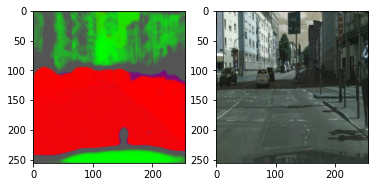

In [37]:
%matplotlib inline
plt.subplot(1,2,1)
plt.imshow(predict_out[400])
plt.subplot(1,2,2)
plt.imshow(val_set_X[400])
plt.show()